# Predicting galaxy redshift from band magnitudes with XGBoost

Zooey Nguyen

2021-07-01

2021-07-06: Update with photoz_utils

2021-07-08: Update with density estimation

mostly same code as `HSC Photo-Z Data and Simple Model Exploration.ipynb`

2021-07-16: Update with photoz_metrics and v3 crossmatched data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize': (10,10)})
from photoz_metrics import *
from photoz_utils import *

## Import photoz data + filter out bad objects

In [2]:
df = import_photoz_data('/data/HSC/HSC_v3/trimmed_forced_forced2_spec_z_matched_online.csv')
df = clean_photoz_data(df)

               g_mag          r_mag          i_mag          z_mag  \
count  122131.000000  122131.000000  122131.000000  122131.000000   
mean       23.162820      22.326554      21.686068      21.338282   
std         1.353069       1.297307       1.289589       1.295834   
min        16.207699      15.334381      14.787071      14.448893   
25%        22.456253      21.694773      21.087153      20.725318   
50%        23.241270      22.475418      21.830765      21.468258   
75%        23.998854      23.103663      22.370147      22.019053   
max        34.930744      32.492126      31.049211      28.897368   

               y_mag          zspec  
count  122131.000000  122131.000000  
mean       21.158419       0.839552  
std         1.313658       0.531311  
min        14.223459       0.010250  
25%        20.522226       0.548421  
50%        21.289488       0.745700  
75%        21.859919       0.978300  
max        34.435986       3.996137  


## Make train and test sets on filtered data

In [3]:
X_train, X_test, y_train, y_test = split_photoz_data(df)
X_train

,g_mag,r_mag,i_mag,z_mag,y_mag
112825,20.568955,20.256933,19.787699,19.539837,19.383953
32971,23.416458,22.544807,21.745821,21.424551,21.192684
113710,23.157631,23.048843,22.590868,22.587530,22.511169
9125,21.758896,20.070270,19.150595,18.738686,18.557207
43239,22.759848,22.074736,20.925404,20.440670,20.464979
...,...,...,...,...,...
87894,24.704767,24.335134,23.974430,23.332426,23.291296
108003,23.095077,23.083691,22.741499,22.493507,22.433220
55621,24.175625,22.934841,21.866703,21.230675,20.786694
122870,22.104733,21.360924,20.077709,19.790119,19.287605


## Train simple XGBoost regression

In [4]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=32, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

## Evaluate training point estimates

In [5]:
y_train_pred = xgb_model.predict(X_train)
y_train_pred = pd.Series(y_train_pred, index=y_train.index)

In [6]:
print_point_metrics(y_train_pred, y_train)

Bias: 0.01794567095398035
Scatter: 0.11877292393591618
Conventional outlier rate: 0.2447699173012364
Biweight outlier rate: 0.1467084254482928
Losses: 
112825    0.269067
32971     0.031550
113710    0.789233
9125      0.707009
43239     0.121741
            ...   
87894     0.080261
108003    0.230760
55621     0.000083
122870    0.821995
2261      0.861880
Length: 97704, dtype: float64


In [7]:
print_point_metrics(y_train_pred, y_train, binned=True)

            count      bias   scatter  outlier_conv  outlier_bw  mean_loss
bin                                                                       
(0.0, 0.2]   4638  0.356675  0.327956      0.591203    0.022639   0.597022
(0.2, 0.4]   7474  0.245419  0.216239      0.691062    0.040005   0.599239
(0.4, 0.6]  18709  0.081511  0.075397      0.232776    0.130579   0.309289
(0.6, 0.8]  24540  0.026085  0.053834      0.079584    0.108394   0.138068
(0.8, 1.0]  19420 -0.009821  0.053097      0.047786    0.099897   0.111230
(1.0, 1.2]   9524 -0.050874  0.071981      0.098278    0.091033   0.202850
(1.2, 1.4]   4147 -0.100251  0.103528      0.310345    0.041717   0.345150
(1.4, 1.6]   2625 -0.154248  0.114958      0.495619    0.020190   0.469057
(1.6, 1.8]   1708 -0.192000  0.116442      0.645199    0.018735   0.544454
(1.8, 2.0]   1177 -0.227501  0.124164      0.708581    0.011045   0.612504
(2.0, 2.2]    774 -0.246814  0.116106      0.789406    0.028424   0.653893
(2.2, 2.4]    519 -0.2666

<AxesSubplot:xlabel='zspec'>

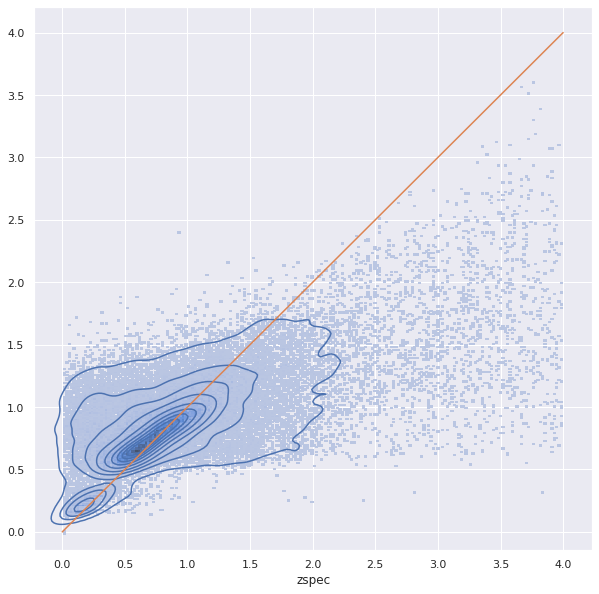

In [14]:
sns.histplot(x=y_train, y=y_train_pred)
sns.kdeplot(x=y_train, y=y_train_pred)
sns.lineplot(x=[0,4], y=[0,4])

## Evaluate test point estimates

In [9]:
y_test_pred = xgb_model.predict(X_test)
y_test_pred = pd.Series(y_test_pred, index=y_test.index)

In [10]:
print_point_metrics(y_test_pred, y_test)

Bias: 0.020012792380060776
Scatter: 0.12435640059108434
Conventional outlier rate: 0.26356081385352276
Biweight outlier rate: 0.15961845498833258
Losses: 
106608    0.806846
57458     0.116446
117556    0.419714
49519     0.854691
83704     0.921749
            ...   
40879     0.037505
6283      0.948836
110763    0.030915
107849    0.613729
6768      0.567086
Length: 24427, dtype: float64


In [11]:
print_point_metrics(y_test_pred, y_test, binned=True)

            count      bias   scatter  outlier_conv  outlier_bw  mean_loss
bin                                                                       
(0.0, 0.2]   1201  0.387441  0.386641      0.596170    0.040799   0.604392
(0.2, 0.4]   1780  0.275911  0.247028      0.706742    0.044382   0.625571
(0.4, 0.6]   4821  0.082754  0.077942      0.250570    0.147065   0.323927
(0.6, 0.8]   6147  0.027152  0.056553      0.096144    0.119245   0.151894
(0.8, 1.0]   4832 -0.010831  0.054210      0.057119    0.110306   0.121319
(1.0, 1.2]   2378 -0.052566  0.075973      0.123633    0.099664   0.219902
(1.2, 1.4]   1023 -0.104526  0.113296      0.337243    0.036168   0.365008
(1.4, 1.6]    657 -0.172326  0.119686      0.561644    0.024353   0.504778
(1.6, 1.8]    407 -0.221942  0.120509      0.724816    0.041769   0.600780
(1.8, 2.0]    269 -0.252525  0.116739      0.806691    0.040892   0.663944
(2.0, 2.2]    186 -0.291553  0.106504      0.892473    0.026882   0.737620
(2.2, 2.4]    126 -0.3031

<AxesSubplot:xlabel='zspec'>

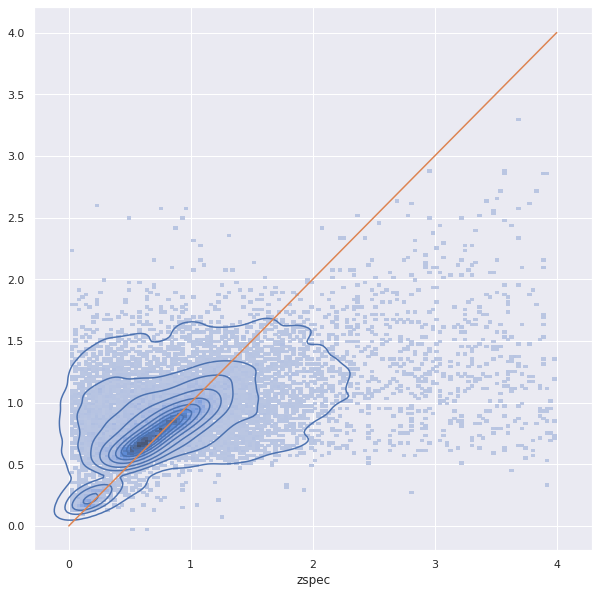

In [13]:
sns.histplot(x=y_test, y=y_test_pred)
sns.kdeplot(x=y_test, y=y_test_pred)
sns.lineplot(x=[0,4], y=[0,4])